In [31]:
import pickle
from phystables import BasicTable, SimpleTable, make_noisy
from phystables.constants import *
import define_tables
from define_tables import WallData, GoalData, BallData, TableData
import pygame as pg
import argparse
import numpy as np
import pandas as pd
from scipy.stats import entropy


DEF_NOISE = {
"kapv": KAPV_DEF, # VonMises precision on initial velocity angle estimation
"kapb": KAPB_DEF, # VonMises precision on the bounce angle estimation
"kapm": KAPM_DEF, # VonMises precision on the motion jitter
"perr": PERR_DEF  # Gaussian error on initial position estimation
}

def _ballhit(balllist):
    blcol = list(map(lambda b: b.col, balllist))
    print("Observed ball collisions: ", blcol)

def _goalhit(ball, goal):
    gtype = get_const(goal.ret)
    print("Ball", ball.col, "hit goal", gtype)

        
def getTable(tables_file, table_id, purpleBall, goldBall, noisy, callback=False, printTable=False):
    '''
    tables_file: File name with tables
    table_id: Table from table_files
    trial_id: Determines which simulation to run 
    noisy: T/F
    callback: T/F
    '''
    with open(tables_file, 'rb') as input:
        tablesData = pickle.load(input)
    tableData = tablesData[table_id]
    

            
    
    table = BasicTable(dims=tableData.dims)
    if printTable:
        print('\nWall Data:')
    for i, wall in enumerate(tableData.walls):
        table.add_wall(upperleft=wall.upperleft, lowerright=wall.lowerright)
        if printTable:
            print(str(i)+ ':', 'wall.upperleft', wall.upperleft)
            print(str(i)+ ':', 'wall.lowerright', wall.lowerright)

    if printTable:
            print('\nGoal Data:')
    for i, goal in enumerate(tableData.goals):
        table.add_goal(upperleft=goal.upperleft, lowerright=goal.lowerright, onreturn=goal.onreturn, color=goal.color)
        if printTable:
            print(str(i)+ ':', 'goal.upperleft', goal.upperleft)
            print(str(i)+ ':', 'goal.lowerright', goal.lowerright)
            print(str(i)+ ':', 'goal.onreturn', goal.onreturn)
            print(str(i)+ ':', 'goal.color', goal.color)
        
    balls = tableData.balls
    if purpleBall and goldBall:
        ball_id=2
    elif purpleBall:
        ball_id=0
    elif goldBall:
        ball_id=1
    if ball_id == 0 or ball_id==1:
        table.add_ball(initpos=balls[ball_id].initpos, initvel=balls[ball_id].initvel, color=balls[ball_id].color)
        if printTable:
            print('\nBall Data:')
            print(str(ball_id)+ ':'+ ':', 'balls.color', balls[ball_id].color)
            print(str(ball_id)+ ':', 'balls.initpos',    balls[ball_id].initpos)
            print(str(ball_id)+ ':', 'balls.initvel',    balls[ball_id].initvel)
    else:
        table.add_ball(initpos=balls[0].initpos, initvel=balls[0].initvel, color=balls[0].color)
        table.add_ball(initpos=balls[1].initpos, initvel=balls[1].initvel, color=balls[1].color)
        if printTable:
            print('\nBall Data:')
            print(str(0)+ ':', 'balls.color',   balls[0].color)
            print(str(0)+ ':', 'balls.initpos', balls[0].initpos)
            print(str(0)+ ':', 'balls.initvel', balls[0].initvel)
            print(str(1)+ ':', 'balls.color',   balls[1].color)
            print(str(1)+ ':', 'balls.initpos', balls[1].initpos)
            print(str(1)+ ':', 'balls.initvel', balls[1].initvel)
        
    if noisy:
        table = make_noisy(table, **DEF_NOISE)
        
    if callback:
        table.on_ballhit = _ballhit
        table.on_goalhit = _goalhit
    
    return table

def run_to_end(trial, max_time=10.):
    while True:
        r = trial.step(t=max_time, maxtime=max_time)
        if r is not None:
            if isinstance(r, list):
                r = r[0]
            return [r, trial.tm]
    
def run_simulations(tables_file, table_id, purpleBall, goldBall, noisy, num_simulations, max_time, callback=False):    
    simulations = []
    for i in range(num_simulations):
        table = getTable(tables_file, table_id, purpleBall, goldBall, noisy, callback)
        ret, simTime = run_to_end(table, max_time)
        goalHit = get_const(ret)
        ballHit = None
        ballHit = None
        simulation = [table_id, purpleBall, goldBall, goalHit, ballHit, simTime, noisy]
        simulations.append(simulation)
    return simulations

In [2]:
!python define_tables.py

pygame 2.0.0 (SDL 2.0.12, python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Darwin (64bit) [/Users/julio/Packages/anaconda3/envs/physenv/lib/python3.7/site-packages/pymunk/libchipmunk.dylib]


# Run Simulations and Save to Lookup Table

In [3]:
columns = ['tableID', 'purpleBall', 'goldBall', 'goalHit', 'ballHit', 'simTime', 'noisy']
LookUpTable = pd.DataFrame(columns=columns)



simulations = run_simulations(tables_file='tables_metadata.pkl', 
                              table_id=0, 
                              purpleBall=True,
                              goldBall=False,
                              noisy=True, 
                              num_simulations=5000, 
                              max_time=10)
LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)  

print('here')

simulations = run_simulations(tables_file='tables_metadata.pkl', 
                              table_id=0, 
                              purpleBall=False,
                              goldBall=True,
                              noisy=True, 
                              num_simulations=5000, 
                              max_time=10)
LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)

print('here2')

simulations = run_simulations(tables_file='tables_metadata.pkl', 
                              table_id=0, 
                              purpleBall=True,
                              goldBall=True,
                              noisy=True, 
                              num_simulations=5000, 
                              max_time=10)
LookUpTable = LookUpTable.append(pd.DataFrame(data=simulations, columns=columns), ignore_index=True)  

print('here3')


# Save LookUpTable to file
LookUpTable.to_pickle("LookUpTable.pkl")

# Display Table Up to x columns
pd.set_option("display.max_rows", 100, "display.max_columns", 7)
LookUpTable

here
here2
here3


,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,GREENGOAL,None,1.416,True
1,0,True,False,GREENGOAL,None,1.264,True
2,0,True,False,REDGOAL,None,1.474,True
3,0,True,False,GREENGOAL,None,1.444,True
4,0,True,False,GREENGOAL,None,1.335,True
...,...,...,...,...,...,...,...
14995,0,True,True,REDGOAL,None,1.377,True
14996,0,True,True,REDGOAL,None,1.398,True
14997,0,True,True,GREENGOAL,None,1.360,True
14998,0,True,True,GREENGOAL,None,1.393,True


In [20]:
pd.set_option("display.max_rows", 1000, "display.max_columns", 7)
LookUpTable

,tableID,purpleBall,goldBall,goalHit,ballHit,simTime,noisy
0,0,True,False,GREENGOAL,None,1.416,True
1,0,True,False,GREENGOAL,None,1.264,True
2,0,True,False,REDGOAL,None,1.474,True
3,0,True,False,GREENGOAL,None,1.444,True
4,0,True,False,GREENGOAL,None,1.335,True
...,...,...,...,...,...,...,...
14995,0,True,True,REDGOAL,None,1.377,True
14996,0,True,True,REDGOAL,None,1.398,True
14997,0,True,True,GREENGOAL,None,1.360,True
14998,0,True,True,GREENGOAL,None,1.393,True


# Read File, Select Values, and Turn into List

In [ ]:
# Read Table In
unpickledLookUpTable = pd.read_pickle("LookUpTable.pkl")

# Group Table and Select Group by values
simulation_groups = unpickledLookUpTable.groupby(['tableID', 'purpleBall'])
group_simulations = simulation_groups.get_group(name=(0,True)) # return dataframe for just tableID=0 and purpleBall=True
# turn into a list
group_simulations.values.tolist()

In [36]:
################
# Small Oracle #
################

import random

def small_oracle(samples, num_sim_1, num_sim_2, iters=1000):
    '''
    samples:        Pre-run samples to draw from, list [Ball_1, Ball_2]
    num_sim_1:      Number of simulations for ball 1
    num_sim_2:      Number of simulations for ball 2
    samples:        Number of samples (each sample has num_sim_1 + 2 sims)
    Return tuple(# green wins, # red wins, avg total time)
    # green wins:   Number of samples where #G > #R + 0.5 * ties
    # red wins:     Number of samples where #G < #R + 0.5 * ties
    avg total time: Average total time for a sample
    '''
    g_wins = 0  # track green wins
    r_wins = 0  # track red wins
    total_time = 0  # total time

    for _ in range(iters):  # get samples
        # wins for a fixed sample
        sample_g_wins = 0
        sample_r_wins = 0
        sample_time = 0
        # simulations for ball 1
        for sim_1 in range(num_sim_1):
            table_id,_, _, outcome, _, time, _ = random.choice(samples[0])
            if outcome == 'GREENGOAL':
                sample_g_wins += 1
            if outcome == 'REDGOAL':
                sample_r_wins += 1
            sample_time += time
        # simulations for ball 2
        for sim_2 in range(num_sim_2):
            table_id,_, _, outcome, _, time, _ = random.choice(samples[1])
            if outcome == 'GREENGOAL':
                sample_g_wins += 1
            if outcome == 'REDGOAL':
                sample_r_wins += 1
            sample_time += time
        if sample_g_wins > sample_r_wins:
            g_wins += 1
        if sample_g_wins < sample_r_wins:
            r_wins += 1
        if sample_g_wins == sample_r_wins:
            g_wins += 0.5
            r_wins += 0.5
        total_time += sample_time
    return (g_wins/iters, r_wins/iters, total_time/iters)

In [ ]:
small_oracle([samples1, samples2], 5, 5, 10)

In [64]:
def entropyReward(p,q, alpha):
    return -entropy(p,q)*alpha

def cost(time, alpha):
    return time*alpha

def big_oracle(table_id, max_simulations, LookUpTable, iters, rewardFn, costFn, alpha, beta):
    
    utilities = []
    num_simulations = []
    # purple simulations
    
    green_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'GREENGOAL')).values
    red_truth = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall', 'goalHit']).get_group(name=(0,True, True, 'REDGOAL')).values
    p = np.array([green_truth.shape[0], red_truth.shape[0]]) / np.sum([green_truth.shape[0], red_truth.shape[0]])
    
    for num_purpleBall_sims in range(max_simulations):
        for num_goldBall_sims in range(max_simulations):
        #print(num_purpleBall_sims, num_goldBall_sims)
            
            
            purpleBall_sims = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(table_id,True, False)).values.tolist()            
            goldBall_sims = LookUpTable.groupby(['tableID', 'purpleBall', 'goldBall']).get_group(name=(table_id,False, True)).values.tolist()
            simulations = [purpleBall_sims, goldBall_sims]
            
            q_green, q_red, avg_simTime = small_oracle(simulations, 
                                                       num_purpleBall_sims, 
                                                       num_goldBall_sims, 
                                                       iters)
            q = np.array([q_green, q_red])
            utility = rewardFn(p,q, alpha) - cost(avg_simTime, beta)
            
            utilities.append(utility)
            
            ##print((num_purpleBall_sims,num_goldBall_sims))
            
            num_simulations.append((num_purpleBall_sims,num_goldBall_sims))
            
    
    return (utilities, num_simulations)
            
            
            
            
            
            

In [68]:
optimum = big_oracle(table_id=0, 
                     max_simulations=25, 
                     LookUpTable=LookUpTable, 
                     iters=10000, 
                     rewardFn=entropyReward, 
                     costFn=cost, 
                     alpha=100, 
                     beta=5)

In [72]:
utilities = optimum[0]
simulations = optimum[1]

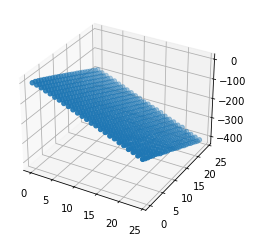

In [74]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array(simulations)[:,0]
Y = np.array(simulations)[:,1]
#X, Y = np.meshgrid(X, Y)
Z = np.array(utilities)
ax.scatter(X, Y, Z)
#surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

plt.show()

In [66]:
print(np.argmax(utilities))
utilities


0


[-3.261413308179273,
 -7.661876496078943,
 -15.190192199980551,
 -22.27031536514141,
 -29.923096383307985,
 -37.70346714761851,
 -45.06003927610756,
 -53.30762874777753,
 -60.59085455463192,
 -69.3647725823404,
 -76.02400473407673,
 -84.4648713937676,
 -92.10083718377359,
 -100.50236661303197,
 -108.56187878804573,
 -116.93414085202541,
 -124.33829820319946,
 -133.79163860567252,
 -140.50991280640235,
 -148.71406205814233,
 -156.33833122639118,
 -165.2976286821137,
 -172.5597065754194,
 -182.0811409358181,
 -188.3051658504081,
 -7.6546655677132245,
 -14.941871144366829,
 -22.763059579885336,
 -30.033841011994852,
 -38.249957676682534,
 -45.602376208237445,
 -54.08050134097064,
 -61.48696226930416,
 -69.39703220316272,
 -77.00889424932673,
 -85.4126463869632,
 -93.26347702404817,
 -101.3385882254336,
 -109.16753810559607,
 -117.41493682442871,
 -124.62105464145748,
 -133.61116295470111,
 -141.36558720041626,
 -149.90040448189814,
 -158.32107856177518,
 -165.34893322777987,
 -173.4824541

In [70]:
print(np.argmax(simulations))
simulations

TypeError: '>' not supported between instances of 'str' and 'bool'

In [73]:
simulations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4,